# Customer Segmentation

## Background

This dataset contains all purchases made for an online retail company based in the UK during an eight month period. We could use cluster analysis combined with RFM analysis to do a customer segmentation.

## Prepare and Explore the Data

For this experiment, we will use [this](https://www.kaggle.com/vijayuv/onlineretail) data from Kaggle platform.

In [1]:
# Package imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', None)

In [2]:
# Load data
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Since we want to segment our customers, we have to make sure that `CustomerID` is not null.

In [3]:
# Check missing value
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

We could see that there is missing value in `CustomerID` columns. We could remove those missing values.

In [35]:
df['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Finland',
       'Austria', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Israel', 'Saudi Arabia', 'Czech Republic',
       'Canada', 'Unspecified', 'Brazil', 'USA', 'European Community',
       'Bahrain', 'Malta', 'RSA'], dtype=object)

In [4]:
# Remove missing value
df = df[df["CustomerID"].notna()]

df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


**Then we could do some descriptive statistic, on integers/float variables**

In [6]:
# Simple descriptive statistic
# negative value is detected, logically quantity cannot be in negative value.
df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


Wait, hold on. How come the quantity is a negative number and the unit price is zero? Let's check it.

**A negative value occur, which is improbable due to signifiying amounts of purchase**

**Null value on unit price is also undesirable owing to items prices should not be a 0 value**

In [7]:
# Check anomaly data
quantity_zero = len(df[df["Quantity"] <= 0])
perc_quantity_zero = (len(df[df["Quantity"] <= 0]) / len(df)) * 100
unitprice_zero = len(df[df["UnitPrice"] == 0])
perc_unitprice_zero = (len(df[df["UnitPrice"] == 0]) / len(df)) * 100

print("The data consist of", str(quantity_zero), "rows of data with item quantity less/equal than zero.")
print("About {:.2f}% of total data".format(perc_quantity_zero))
print("")
print("The data consist of", str(unitprice_zero), "rows of data with unit price equal to zero.")
print("About {:.2f}% of total data".format(perc_unitprice_zero))

The data consist of 8905 rows of data with item quantity less/equal than zero.
About 2.19% of total data

The data consist of 40 rows of data with unit price equal to zero.
About 0.01% of total data


**Therefore removing anomaly data is probable.**
**to achieve a better visualisation.**

In [8]:
# Remove anomaly
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,397884.000000,397884.000000
mean,12.988238,3.116488
std,179.331775,22.097877
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


Now we're good to go. Lets do some data exploration!

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


The data contains 406829 rows and 8 columns, each row represents each item in a purchasement. The columns are:
* `InvoiceNo` - Invoice number, to identify each invoice
* `StockCode` - Stock code, to identify each item in the inventory
* `Description` - Item's description
* `Quantity` - Number of purchased item in each invoice
* `InvoiceDate` - Date of purchasement
* `UnitPrice` - Item's price per unit
* `CustomerID` - Customer's identification number
* `Country` - Customer's country of origin

In [10]:
# Check unique value
df[['InvoiceNo', 'StockCode', 'CustomerID', 'Country']].nunique()

InvoiceNo     18532
StockCode      3665
CustomerID     4338
Country          37
dtype: int64

There are 18532 purchasements, 3665 unique item purchased, from 4338 customers that came from 37 countries.

As we seen above, there are 37 countries of customer's origin. Since the retail company is based in the UK, we could simplified the country as UK or Non UK

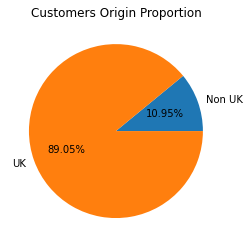

In [11]:
# Simplify country origin
df['Country_isUK'] = np.where(df['Country'] == 'United Kingdom', 'UK', 'Non UK')

customers_origin = df.groupby(['Country_isUK']).size()

_ = plt.title('Customers Origin Proportion')
_ = plt.pie(customers_origin, labels = customers_origin.index, autopct = lambda p: f'{p:.2f}%')
plt.show()

**Piechart has shown a majority purchases coming from UK.**

Next, we could analyze the trend of purchasement. First, lets create **`TotalAmount`** column **(`Quantity` * `UnitPrice`)**. Then, we could transform the **`InvoiceDate`** data type from string to date.

In [12]:
# Create new features and cast date column
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,UK,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,UK,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34


Then plot the trendline.

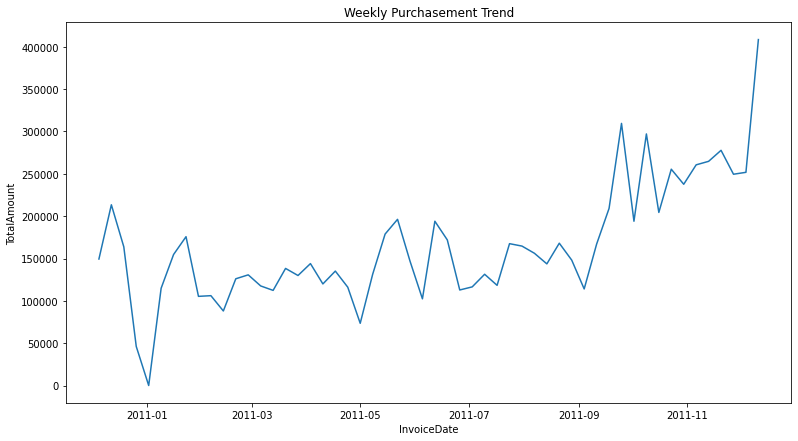

In [13]:
# Plot weekly trend
weekly_purchasements = df.copy()
weekly_purchasements = weekly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1W"))["TotalAmount"].sum()
#frequency in Week (1W), Group by total amounts of purchase.



_ = plt.figure(figsize=(13, 7))  
_ = plt.title('Weekly Purchasement Trend')
_ = sns.lineplot(x = weekly_purchasements.index, y = weekly_purchasements)
plt.show()

In [14]:
pd.DataFrame(weekly_purchasements).sort_values(by=['TotalAmount'], ascending=False).head()

,TotalAmount
InvoiceDate,
2011-12-11,408569.150
2011-09-25,309569.211
2011-10-09,297116.860
2011-11-20,277773.940
2011-11-13,264765.980


In [15]:
weekly_customer = df.copy()
weekly_customer = weekly_customer.groupby(by = pd.Grouper(key="InvoiceDate", freq="1W"))["CustomerID"].count()
pd.DataFrame(weekly_customer).sort_values(by=['CustomerID'], ascending=False).head()

,CustomerID
InvoiceDate,
2011-11-20,16064
2011-11-27,15023
2011-11-13,14501
2011-12-04,13663
2011-11-06,13166


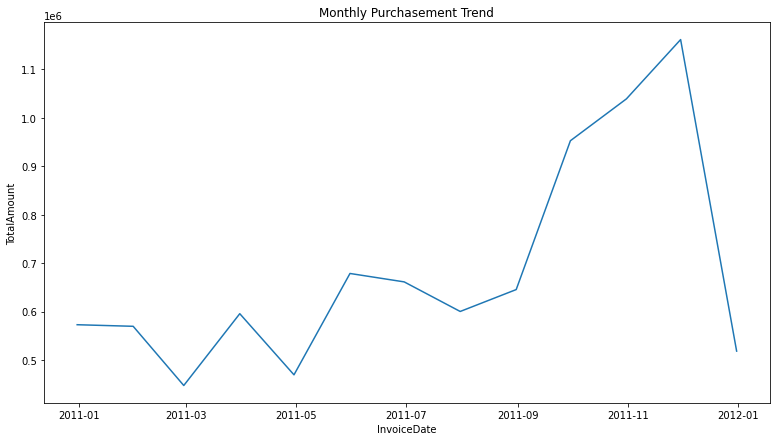

In [16]:
# Plot monthly trend
monthly_purchasements = df.copy()
monthly_purchasements = monthly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()
#frequency in Week (1W), Group by total amounts of purchase.

_ = plt.figure(figsize=(13, 7))  
_ = plt.title('Monthly Purchasement Trend')
_ = sns.lineplot(x = monthly_purchasements.index, y = monthly_purchasements)
plt.show()

Based on the picture above, it can be seen that there was an increase in total purchases at the end of the year.

## RFM

In this project, we would segment the customers using customer's demography and purchasement behavior. To explain the customer's demography, we could use `Country` column while to explain the customer's purchasement behavior we have to transform our data first to get those information. We could use RFM analysis to get those information.

### Recency

To measure customer's recency, we could substract the latest transaction date in the data with each customer's latest transaction.

**the amount of time since the customer's most recent transaction**

In [17]:
# obtaining customer recency. By plotting histogram distribution utiising Customer ID and Invoice date
# to 
recency = df.groupby(['CustomerID'])['InvoiceDate'].max()
recency = max(recency) - recency
recency = recency.dt.days
recency = recency.rename('Recency')

recency.head()

CustomerID
12346.0    325
12347.0      1
12348.0     74
12349.0     18
12350.0    309
Name: Recency, dtype: int64

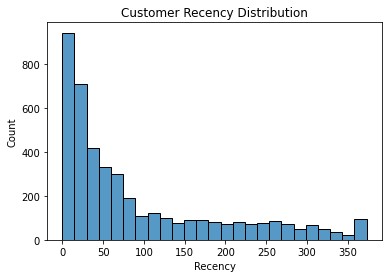

In [18]:
# Recency histogram plot
_ = plt.title('Customer Recency Distribution')
_ = sns.histplot(recency)
plt.show()

### Frequency

To measure customer's purchase frequency, we could count customer's invoice.

In [19]:
# Count frequency
frequency = df.groupby(['CustomerID'])['InvoiceNo'].count()
frequency = frequency.rename('Frequency')

frequency.head()

CustomerID
12346.0      1
12347.0    182
12348.0     31
12349.0     73
12350.0     17
Name: Frequency, dtype: int64

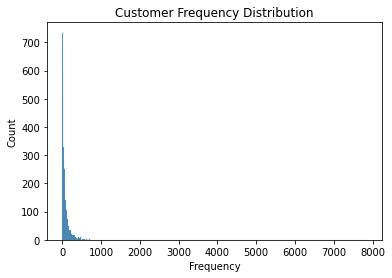

In [20]:
# Frequency histogram plot
_ = plt.title('Customer Frequency Distribution')
_ = sns.histplot(frequency)
plt.show()

### Monetary

To measure customer's monetary, we could sum the customer's total purchasements.

In [21]:
# Sum the money spent
monetary = df.groupby(['CustomerID'])['TotalAmount'].sum()
monetary = monetary.rename('Monetary')
monetary.head()

CustomerID
12346.0    77183.60
12347.0     4310.00
12348.0     1797.24
12349.0     1757.55
12350.0      334.40
Name: Monetary, dtype: float64

In [22]:
df_monetary = pd.DataFrame(monetary).sort_values(by=['Monetary'], ascending=False)
df_monetary.head()

,Monetary
CustomerID,
14646.0,280206.02
18102.0,259657.30
17450.0,194550.79
16446.0,168472.50
14911.0,143825.06


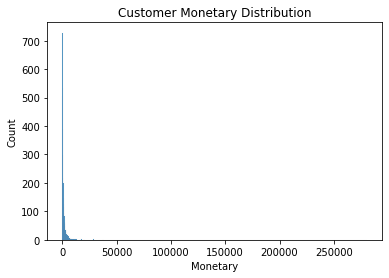

In [23]:
# Monetary histogram plot
_ = plt.title('Customer Monetary Distribution')
_ = sns.histplot(monetary)
plt.show()

### Merge the Data

The data could be separated into two dataframes. The first dataframe (log transformed data) supposed to be used when modeling and the second one (without log transformation) could be used when visualize the result.

In [24]:
# Get customer's country of origin
country = df.groupby(['CustomerID', 'Country_isUK']).size().reset_index().drop(0, axis = 1)

# Merge the data
df_new = country \
    .merge(recency, on = 'CustomerID') \
    .merge(frequency, on = 'CustomerID') \
    .merge(monetary, on = 'CustomerID')

# Set CustomerID as index
df_new = df_new.set_index('CustomerID')

df_new.head()

,Country_isUK,Recency,Frequency,Monetary
CustomerID,,,,
12346.0,UK,325,1,77183.60
12347.0,Non UK,1,182,4310.00
12348.0,Non UK,74,31,1797.24
12349.0,Non UK,18,73,1757.55
12350.0,Non UK,309,17,334.40


In [25]:
df_new.sort_values(by=['Frequency'], ascending=False).head()

,Country_isUK,Recency,Frequency,Monetary
CustomerID,,,,
17841.0,UK,1,7847,40991.57
14911.0,Non UK,0,5675,143825.06
14096.0,UK,3,5111,65164.79
12748.0,UK,0,4595,33719.73
14606.0,UK,0,2700,12156.65


### One Hot Encoding

Since our model could just accept the numeric value, we have to recode the non numeric column. In this case, **Country_UK column** is object shape, required to be converted into numericalby encoding it.

In [26]:
# Recode the non numeric variable

df_new = pd.get_dummies(df_new, columns=['Country_isUK'], drop_first=True)
df_new = df_new.rename(columns = {'Country_isUK_UK': 'Country_UK'})

df_new.head()

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12346.0,325,1,77183.60,1
12347.0,1,182,4310.00,0
12348.0,74,31,1797.24,0
12349.0,18,73,1757.55,0
12350.0,309,17,334.40,0


### Scaling

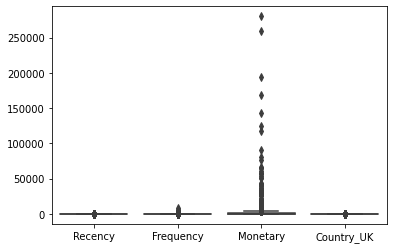

In [27]:
_ = sns.boxplot(data = df_new)
plt.show()

As we could see, there are variation of range in each column. We have to standardize it first.

In [28]:
# Scale the data

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_new)

df_scaled = pd.DataFrame(df_scaled, columns = df_new.columns, index = df_new.index)

df_scaled.head()

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12346.0,2.334574,-0.396578,8.358668,0.326547
12347.0,-0.905340,0.394649,0.250966,-3.062350
12348.0,-0.175360,-0.265435,-0.028596,-3.062350
12349.0,-0.735345,-0.081836,-0.033012,-3.062350
12350.0,2.174578,-0.326635,-0.191347,-3.062350


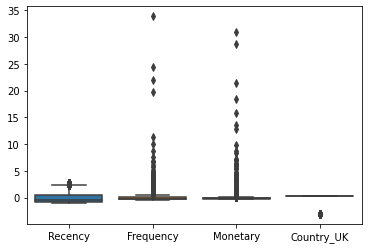

In [29]:
# Plot scaled data
_ = sns.boxplot(data = df_scaled)
plt.show()

## Modeling

In [30]:
# Modeling
possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette = []

for k in possible_k:
    kmeans = KMeans(n_clusters = k, random_state = 123).fit(df_scaled)
    
    silhouette.append(silhouette_score(X = df_scaled, labels = kmeans.labels_))

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

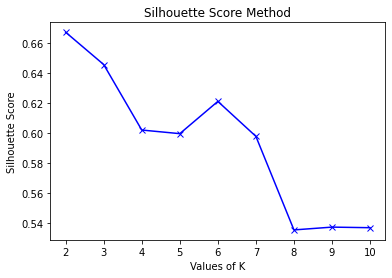

In [31]:
# Plot the score
plt.plot(possible_k, silhouette, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

Using silhouette score, the best K is either 2 or 6

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


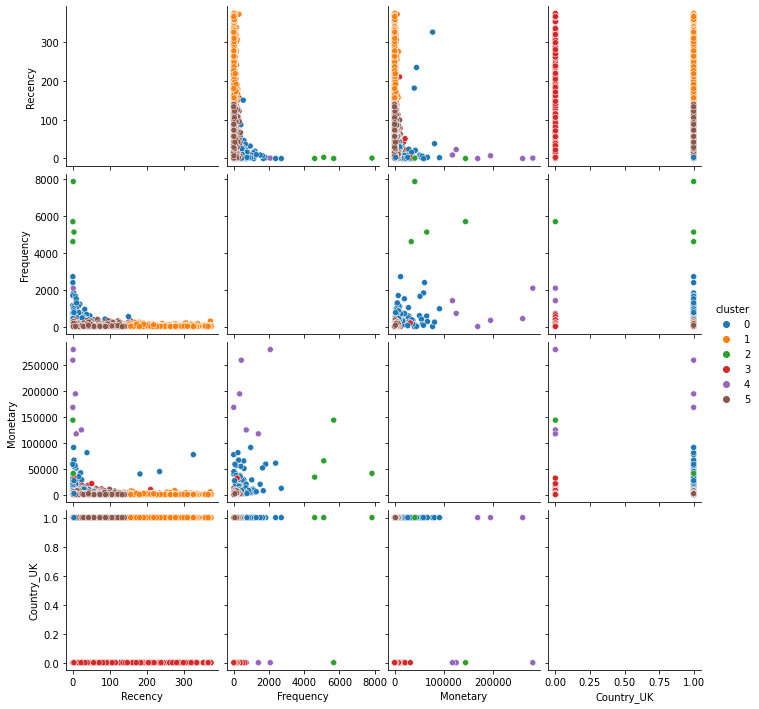

In [32]:
kmeans = KMeans(n_clusters = 6, random_state = 123).fit(df_scaled)

df_result_kmeans = df_new.copy()
df_result_kmeans['cluster'] = kmeans.labels_

_ = sns.pairplot(data = df_result_kmeans, hue = 'cluster', diag_kind = 'None', palette = 'tab10')
plt.show()

In [33]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
df_result_kmeans \
    .drop("Country_UK", axis = 1) \
    .groupby('cluster') \
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max']) \
    .transpose()

cluster                      0            1              2             3  \
Recency   mean       15.234973   246.776618       1.000000     95.405797   
          std        35.305176    65.636727       1.414214    104.638705   
          min         0.000000   143.000000       0.000000      0.000000   
          q25         2.000000   189.000000       0.000000     18.000000   
          median      6.000000   242.000000       0.500000     52.000000   
          q75        16.000000   296.000000       1.500000    136.500000   
          max       325.000000   373.000000       3.000000    373.000000   
Frequency mean      535.360656    27.689979    5807.000000     81.396135   
          std       358.078267    32.176026    1429.730044     96.304061   
          min         1.000000     1.000000    4595.000000      1.000000   
          q25       367.000000     8.250000    4982.000000     21.250000   
          median    450.000000    18.000000    5393.000000     45.000000   
          q75       589.500000    33.000000    6218.000000    101.000000   
          max      2700.000000   297.000000    7847.000000    638.000000   
Monetary  mean    13085.065738   450.793070   70925.287500   2262.538913   
          std     16313.461152   610.367153   50424.336433   3479.689136   
          min      1093.650000     3.750000   33719.730000     51.560000   
          q25      4014.945000   163.225000   39173.610000    459.650000   
          median   6923.130000   305.515000   53078.180000   1025.700000   
          q75     13213.210000   505.542500   84829.857500   2659.962500   
          max     91062.380000  7832.470000  143825.060000  31906.820000   

cluster                       4             5  
Recency   mean         6.666667     42.676884  
          std          8.869423     36.313016  
          min          0.000000      0.000000  
          q25          0.250000     14.000000  
          median       4.000000     31.000000  
          q75          8.500000     64.000000  
          max         23.000000    155.000000  
Frequency mean       826.833333     76.270826  
          std        771.620481     74.030983  
          min          3.000000      1.000000  
          q25        360.500000     22.000000  
          median     572.500000     51.000000  
          q75       1228.500000    107.000000  
          max       2076.000000    385.000000  
Monetary  mean    190863.461667   1341.293935  
          std      67791.993010   1592.871914  
          min     117379.630000      6.200000  
          q25     135804.022500    371.700000  
          median  181511.645000    795.120000  
          q75     243380.672500   1720.300000  
          max     280206.020000  17654.540000

In [34]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Recency"].count()

cluster  Country_UK
0        1              183
1        1              958
2        0                1
         1                3
3        0              414
4        0                3
         1                3
5        1             2773
Name: Recency, dtype: int64

That's it! The customer's behavior really segmented by their country of origin.

What if we separate the customer by its country of origin before doing cluster analysis?

# Question

1. (30 point) Lakukan EDA lebih mendalam dari data yang tersedia. Misalnya: a) Siapa **top 5 customer dengan pembelian terbanyak?** b) **Kapan waktu pembelian** dengan **jumlah customer terbanyak**? (Misal hari apa, jam berapa, bulan apa, minggu ke berapa, dst). EDA juga bisa dilakukan menggunakan business question lain.
2. (30 point) **Apa karakteristik/ciri utama** dari masing**-masing cluster?** Apa **promo yang kira-kira cocok** untuk diberikan ke masing-**masing cluster**?
3. (40 point) Bagaimana jika **segmentation** difokuskan untuk **customer di luar UK**? Apakah terdapat **insight yang menarik**? Apa **karakteristik utama** dari cluster-**cluster non UK**?

## **Answers**

1. Top 5 customer id with the most purchases: 

*   14646
*   18102
*   17450
*   16446
*   14911 

Highest transactions occurs on the month of December: **2011-12-11** with total amount of transactions **408569**

However, most customer visits occurs on 2011-11-20 with total of	**16064** customers



2. insights from each clusters
   
*   **Cluster 0**: low recency, higher spending compared to the 1st and 4th cuslter, UK citizen
*   **Cluster 1**: low spending, high recency which means they have no budget, UK Citizen
*   **Cluster 2**: med-high frequency, low-mid spending, mix of UK and non-UK
*   **Cluster 3**:non-UK,low frequence,low spending but recency spreads vastly
*   **Cluster 4**: mid-low Frequency,low-recency, their spending is quite high mix of UK and Non-UK
*   **Cluster 5**: low-frequency, low-spending, low recency UK citizen

Potential Promo:

*   Bundling discount
*   Free delivery 
*   First purchase discount
*   Daily promo?voucher on different products

3. Promo bundling di non UK countries atau discount ongkir.

inshights: they spend the lowest, perhaps caused by inadequate buying power. 

create a tester version of certain product types, first purchase dicount